In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle

In [15]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [16]:
!cp kaggle.json ~/.kaggle/

In [17]:
!chmod 600 ~/.kaggle/kagle.json

chmod: cannot access '/root/.kaggle/kagle.json': No such file or directory


In [18]:
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:26<00:00, 88.1MB/s]
100% 1.21G/1.21G [00:26<00:00, 48.6MB/s]


In [ ]:
!unzip gtzan-dataset-music-genre-classification

# Libraries

In [78]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pathlib
from PIL import Image
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [ ]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
for genre in genres:
  pathlib.Path(f'/content/Data/Images/{genre}').mkdir(parents=True, exist_ok=True)
  for filename in os.listdir(f'/content/Data/genres_original/{genre}'):
    songname = f'Data/genres_original/{genre}/{filename}'
    y, Fs = librosa.load(songname,mono=True,duration=5)
    plt.specgram(y, NFFT= 2048, Fs=Fs, noverlap=128, cmap='inferno',mode='psd');
    plt.axis('off');
    plt.savefig(f'/content/Data/Images/{genre}/{filename[:-3].replace(".", "")}.png')
    plt.clf()

# Sample Spectrogram - PSD (genre: Blues)

In [129]:
from IPython.display import Image as Img

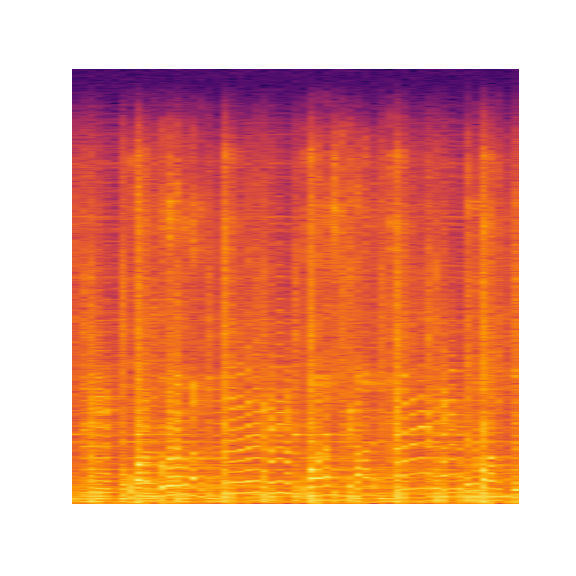

In [130]:
Img('/content/Data/Images/blues/blues00000.png')

# Feature Extraction

**1.** **Spectral Shift - spectral_centroid:**
- Indicates at which frequency the energy of spectrum is centered upon.
- Similar to the Center of Mass in Physics.


**2.** **Spectral Rolloff - spectral_rolloff:**
- Shape feature, indicating the zero point of high frequecies.
- Fraction of 85% of the whole signal energy falls in.


**3.** **Spectral Bandwidth - spectral_bandwidth:**
- Width of one-half of the peak maximum


**4.** **Zero Crossing Rate - zero_crossing_rate:**
- Smoothness measure of a signal
- Oscillation measure

**5.** **MFCC - mfcc:**
- Mel frequency cepstral coefficients
- Shape feature of the spectral envolope

**6.** **Chroma feature - chroma_stft:**
- Energy indicator for each pitch class
- Similarity measure between music

In [23]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [24]:
file = open('/content/Data/dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for genre in genres:
    for filename in os.listdir(f'/content/Data/genres_original/{genre}'):
        songname = f'/content/Data/genres_original/{genre}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {genre}'
        file = open('/content/Data/dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [86]:
data = pd.read_csv('Data/dataset.csv')
data = data.drop(['filename'],axis=1)

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
y = to_categorical(y)
scaler = StandardScaler()

X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [87]:
X_train.shape

(799, 26)

In [88]:
X_test.shape

(200, 26)

In [89]:
y_train.shape

(799, 10)

In [85]:
len(genres)

10

In [123]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [124]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 128)               3456      
                                                                 
 dense_90 (Dense)            (None, 64)                8256      
                                                                 
 dense_91 (Dense)            (None, 32)                2080      
                                                                 
 dense_92 (Dense)            (None, 32)                1056      
                                                                 
 dense_93 (Dense)            (None, 16)                528       
                                                                 
 dense_94 (Dense)            (None, 10)                170       
                                                                 
Total params: 15,546
Trainable params: 15,546
Non-tra

In [125]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,validation_split=0.2,shuffle=True)

Epoch 1/50
20/20 [==============================] - 1s 17ms/step - loss: 13.3301 - accuracy: 0.1878 - val_loss: 11.4412 - val_accuracy: 0.2313
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 10.0293 - accuracy: 0.2582 - val_loss: 8.6317 - val_accuracy: 0.2375
Epoch 3/50
20/20 [==============================] - 0s 6ms/step - loss: 7.5719 - accuracy: 0.2770 - val_loss: 6.5661 - val_accuracy: 0.3125
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 5.7670 - accuracy: 0.3365 - val_loss: 5.0643 - val_accuracy: 0.3313
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 4.4543 - accuracy: 0.3490 - val_loss: 3.9817 - val_accuracy: 0.3125
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 3.5087 - accuracy: 0.3865 - val_loss: 3.2411 - val_accuracy: 0.2875
Epoch 7/50
20/20 [==============================] - 0s 6ms/step - loss: 2.8601 - accuracy: 0.4085 - val_loss: 2.7264 - val_accuracy: 0.3313
Epoch 8/50
20/20

In [126]:
model.evaluate(X_test,y_test)

7/7 [==============================] - 0s 4ms/step - loss: 1.4007 - accuracy: 0.6300


[1.4006853103637695, 0.6299999952316284]

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])